<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/IASAC-UMH.png width="450" height="200"></small>

# <font color="steelblue">Algoritmo k-NN para problemas de clasificación y regresión</font>

**Autoría**: 

*   Fernando Borrás (f.borras@umh.es)
*   Federico Botella (federico@umh.es)
*   Inés Hernández (ines.hernandezp@umh.es)
*   Mª Asunción Martínez Mayoral (asun.mayoral@umh.es)
*   Josep Moltó (j.molto@umh.es)
*   Javier Morales (j.morales@umh.es) 

Departamento de Estadística, Matemáticas e Informática. 

Universidad Miguel Hernández de Elche. 


**Financiación**: El material que aparece a continuación se ha desarrollado dentro del marco del proyecto UNIDIGITAL- IASAC.

**Fecha última edición**: 05/03/2023

**Licencia**: <small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /></small>

No olvides hacer una copia si deseas utilizarlo. Al usar estos contenidos, acepta nuestros términos de uso y nuestra política de privacidad. 


## <font color="steelblue">Configuración del cuaderno</font>

Para garantizar la funcionalidad completa de este cuaderno, es preciso ejecutar la celda de código a continuación.

In [ ]:
#@title <b><font color="steelblue" size="+1"> Configuración de cuaderno

# Cargamos módulos
from io import StringIO 
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
import math             # importamos módulo para cáculos matemáticos

# Esta línea configura matplotlib para mostrar las figuras incrustadas en el jupyter notebook
# Configuraciónde entorno gráfico
%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    print('Comenzamos....')

with Capturing(output) as output:
    # Librerías
    import os
    !pip install jupyterquiz
    from jupyterquiz import display_quiz
    import json
    import base64
    # Lectura ficheros json
    # A configurar pra cada cuaderno en función de las preguntas de autoevalaución
    for i in range(1,7):
      !wget {f"https://raw.githubusercontent.com/ia4legos/MachineLearning/main/autoeval/auto_50_{i}.json"}
    print("Cuaderno configurado")

if output[-1]=='Cuaderno configurado':
    print(output[-1])
else: 
    print(output[:-2])

Cuaderno configurado


# <font color="steelblue">Introducción</font>

**Descripción:** En este cuaderno se presenta el algoritmo de los k vecinos más cercanos para realizar tareas de clasificación y regresión en un proceso de aprendizaje automático, con aplicaciones en diferentes situaciones con bancos de datos reales.

**Nivel de Formación:** B

**Recomendaciones antes de usarlo:** Se requieren conocimientos básicos de álgebra matricial.


## <font color="steelblue">Objetivos de aprendizaje</font>

* Conocer los algoritmos de los k vecinos más cercanos para tareas de clasificación o regresión en la implantación de un proceso de aprendizaje automático. 
* Conocer los diferentes tipos de métricas utilizadas en los algoritmos de los k vecinos más cercanos.
* Determinar el número óptimo de vecinos basado en diferentes métricas de validación en función del tipo de tarea a resolver.
* Aplicar los algoritmos de k vecinos más cercanos para tareas de clasificación o regresión en situaciones reales. 

## <font color="steelblue">Contenidos</font>

1. Algoritmo k-NN para problemas de clasificación y regresión.
 * Etapas en k-NN.
 * Métricas de distancia.
 * Predictoras irrelevantes y problemas de escala.
 * Seleccionando el número de vecinos (k).
 * Ponderación de los vecionos más cercanos.
 * Ventajas y desventajas de k-NN.
2. k-NN en Scikit-Learn.
3. Aplicaciones.
  * k-NN en problemas de regresión.
  * k-NN en problemas de clasificación.

# <font color="steelblue">Algoritmo k-NN para problemas de clasificación y regresión</font>

El algoritmo de los k vecinos más cercanos (k-NN) es un algoritmo de aprendizaje automático que pertenece a los algoritmos de aprendizaje supervisado simples y fáciles de aplicar. Estos pueden ser utilizados para resolver problemas de clasificación y de regresión. 


Este algoritmo utiliza el concepto de proximidad para hacer clasificaciones o predicciones sobre un punto de la muestra de validación a partir de los k vecinos más cercanos de la muestra de entrenamiento. En los problemas de clasificación el algoritmo k-NN calcula la probabilidad de que los datos de prueba pertenezcan a las clases de los 'k' datos de entrenamiento más cercanos y se asignará la clase que tenga la mayor probabilidad de ocurrencia. En el caso de la regresión, el valor utilizado es la media de los 'k' puntos de entrenamiento seleccionados.

El aprendizaje del algoritmo es:

1. Aprendizaje basado en memoria: aquí no estimamos pesos a partir de los datos de entrenamiento para predecir la respuesta (como en los algoritmos basados en modelos) sino que utilizamos los valores completos de entrenamiento para predecir la salida de los datos no validación.

2. Aprendizaje perezoso: el proceso de aprendizaje se pospone a un momento en el que se solicita la predicción sobre una nueva observación que se desea clasificar o predecir.

3. No paramétrico: en k-NN, no hay una forma predefinida para obtener una función para la clasificación o regresión ya que esta depende de los datos de entrenamiento el valor de k seleccionado.


Las mayores aplicaciones del k-NN son en sistemas de recomendación simples, reconocimiento de patrones, extracción de datos, predicciones del mercado financiero, detección de intrusos y más. 

En este cuaderno nos centraremos en el funcionamiento de dicho algoritmo en problemas de clasificación pero se mostrará como modificarlo para ser usado en problemas de regresión.

## <font color="steelblue">Etapas en k-NN</font>

Imaginemos que tenemos una matriz de predictoras $X$ y un vector de respuestas $y$, de tipo categórico para un problema de clasificación y de tipo numérico para un problema de regresión, de forma que dividimos el conjunto de muestras en entrenamiento y validación:

$$X = (X_e, X_v); \quad y = (y_e, y_v).$$

La lógica de funcionamiento detrás del algoritmo k-NN es una de las más sencillas de todos los algoritmos de aprendizaje automático supervisados y se organiza a traves de las etapas siguientes:

* **Etapa 1. Fijar valor de k.** Establecer el número de k vecinos que vamos a utilizar.

* **Etapa 2. Obtención de distancias.** Se debe selecionar el tipo de distancia $d$, y calcular la distancia de todos los elementos de la muestra de entrenamiento con respecto a cada uno de los elementos de la muestra de validación utilizando para ello las variables predictoras:

$$d_v= d(X_e,X_v).$$

>$d_v$ es una matriz de dimensiones igual a muestras de entrenamiento por muestras de validación.

* **Etapa 3. Identificación de k vecinos.** Para cada una de las muestras del conjunto de validación se deben seleccionar los k vecinos más cercanos (basado en las distancias de la etapa 2) de la muestra de entrenamiento. Debemos tomar los k elementos con menor valor de distancia para cada una de las columnas de $d_v$ e identificar dichas observaciones para seleccionar los correspondientes valores del vector $y_e$.

* **Etapa 4. Predicción.** Para un problema de clasificación se establece la etiqueta mayoritaria de la variable respuesta dentro de los k vecinos seleccionados para cada una de las muestras de validación, y se asigna como respuesta dicho valor, es decir, se calcula la frecuencia de cada valor de la respuesta para el conjunto de k vecinos de $y_e$ y se asigna como valor de predicción el mayoritario. En un problema de regresión para cada una de las muestras de validación se calcula la media de la variable respuesta del conjunto de k vecinos seleccionados dentro de $y_e$, y se asigna dicho valor como predicción de la respuesta. 

* **Etapa 5. Validación.** Una vez obtenida la predicción con los k vecinos debemos validar la solución comparándola con los valores reales observados $y_v$. Para ello se utilizan las métricas habituales en función de que el problema sea de clasificación o regresión.

## <font color="steelblue">Métricas de distancia</font>

Para determinar qué elementos de la muestra de entrenamiento están más cerca de cada uno de los puntos de la muestra de validación, es necesario calcular la distancia entre ellos, a partir de alguna función de distancia. 

Si bien hay varias medidas de distancia entre las que puede elegir, se presentan a continuación las más habituales. Cualquier otra función que cumpla con los requisitos para ser distancia puede ser utilizada dentro de este algoritmo.

En todos los casos consideramos que el conjunto de muestras de entrenamiento es $n_e$, el conjunto de muestras de validación es $n_v$, y el número de predictoras es $p$.

* **Distancia euclídea**: esta es la medida de distancia más utilizada y está limitada a variables predictoras de tipo numérico. Se define la distancia como:

$$d(x_{e_i},x_{v_j}) = \sqrt{\sum_{l=1}^{p} (x_{v_l}-x_{e_l})^2}, \quad i=1,...,n_e, \quad j=1,...,n_v$$

* **Distancia Manhattan**: esta es también otra métrica de distancia popular, que mide la distancia en términos del valor absoluto entre dos puntos. También se conoce como distancia de taxi o distancia de la ciudad, ya que comúnmente se visualiza con una cuadrícula, que ilustra cómo se puede navegar de una dirección a otra a través de las calles de la ciudad. Se define como:

$$d(x_{e_i},x_{v_j}) = \sum_{l=1}^{p} |x_{v_l}-x_{e_l}|, \quad i=1,...,n_e, \quad j=1,...,n_v$$

* **Distancia Minkowski**: esta medida de distancia es la forma generalizada de las métricas de distancia Euclidiana y Manhattan. El parámetro, g, en la fórmula a continuación, permite la creación de otras métricas de distancia. La distancia euclidiana se representa mediante esta fórmula cuando g es igual a dos, y la distancia de Manhattan se denota con g igual a uno. Se define como:

$$d(x_{e_i},x_{v_j}) = \left(\sum_{l=1}^{p} |x_{v_l}-x_{e_l}| \right)^{1/g}, \quad i=1,...,n_e, \quad j=1,...,n_v$$

* **Distancia Hamming**: esta métrica se usa típicamente cuando las variables predictoras son de tipo booleano o de cadena, identificando los puntos donde los vectores no coinciden. Como resultado, también se la conoce como la métrica de superposición. Esto se puede representar con la siguiente fórmula: 

$$d(x_{e_i},x_{v_j}) = \left(\sum_{l=1}^{p} |x_{v_l}-x_{e_l}| \right), \quad i=1,...,n_e, \quad j=1,...,n_v, \quad \text{con}$$ 

$$d = 0 \quad \text{ si } x_{v_l}=x_{e_l} \quad \text{ y } \quad d = 1 \quad \text{ si } x_{v_l}\neq x_{e_l}$$


Si en el conjunto de predictoras disponemos tanto de variables numéricas como variables booleanas o de tipo cadena podemos utilizar una métrica que combina la distancia euclídea y la Hamming en una sola. Esta distancia se define como:

$$d_M(x_{e_i},x_{v_j}) = \sqrt{\sum_{l=1}^{p} d(x_{v_l},x_{e_l})}$$ 

donde $d$ se corresponde con la distancia euclídea cuando la predictora es numérica, y con Hamming cuando la predictora es booleana o cadena. Sim embargo, hay que tener cuidado con esta métrica cuando entre las predictoras tenemos una variable ordinal con más de dos categorías ya que la distancia Hamming no respeta el orden y asigna la misma diferencia entre los diferentes niveles de la variable independientemente de lo cerca o lejos que estén dichas categorías.

## <font color="steelblue">Predictoras irrelevantes y problemas de escala</font>

Dos aspectos muy relevantes en la implementación del algoritmo k-NN son la utilización de variables predictoras que no aportan información suficiente para explicar el comportamiento de la respuesta, y los efectos de las escalas de medida en que cada una de las predictoras ha sido registrada, dado que la elección de los k-vecinos se realiza en términos de distancia y esta puede verse muy afectada por estas situaciones.

En cuanto a la primera dificultad, la magnitud del efecto causado por las predictoras irrelevantes depende de cuántas de ellas se utilicen para realizar el entrenamiento del modelo. En un conjunto con cientos de predictoras, de las cuales sólo una es irrelevante, no hay motivos de preocupación ya que es poco probable que un solo culpable distorsione el valor de la distancia de forma significativa. Pero las cosas pueden cambiar a medida que aumenta el porcentaje de predictoras irrelevantes. Si la gran mayoría de ellas no tiene capacidad para explicar el comportamiento de la respuesta, entonces independientemente de la distancia utilizada esta carecerá prácticamente de sentido y el rendimiento del algoritmo será pésimo.
Para solucionar este problema se puede utilizar el siguiente procedimiento:

1. Realizar un análisis previo del conjunto de predictoras para tratar de determinar un conjunto inicial mínimo de las que estén muy relacionadas con la respuesta que deseamos predecir. 
2. Ir añadiendo poco a poco el resto de predictoras al conjunto anterior e ir valorando la capacidad del algoritmo hasta que esta se estabilice o disminuya.


Para explicar cómo influye el efecto de escala en el cálculo de las distancias consideramos el ejemplo siguiente. Tenemos tres variables predictoras de forma que la primera es de tipo booleano (verdadero o falso), la segunda es una variable numérica con valores en el rango [0, 1], y la tercera es una variable numérica con valores en el rango [0, 1000], de forma que queremos evaluar la distancia entre dos muestras con vectores de datos dados por $p_1= (V, 0.2, 254)$ y $p_2= (F, 0.1, 194)$. Utilizando la distancia $d_M$ tenemos que:

$$d_M(p_1, p_2) = \sqrt{(1-0)^2 + (0.2-0.1)^2 + (254-194)^2}$$

Al estudiar en detalle esta distancia observamos que la tercera predictora domina por completo el valor de la distancia, reduciendo las otras dos predictoras a una virtual insignificancia. No importa cómo modifiquemos sus valores dentro de sus rangos, la distancia apenas cambiará. Afortunadamente, la situación es fácil de rectificar. Si dividimos, en el conjunto de entrenamiento, todos los valores del tercer atributo por 1000, modificamos su escala de forma que, los impactos de las predictoras se volverán más equilibrados. Por tanto, la mejor forma de evitar los posibles problemas de escala es normalizar o estandarizar las variables para conseguir que todas ellas se encuenten en una misma escala y se afecte lo menos posible el comportamiento del algoritmo k-NN. Sin embargo, incluso en este caso es necesario estudiar con detalle la normalización o estandarización propuesta para evitar comportamientos erróneos del algoritmo k-NN. 


## <font color="steelblue">Seleccionando el número de vecinos (k)</font>

Uno de los aspectos más relevantes en la utilización del algoritmo k-NN es la selección de k. Para dicha elección se utiliza una estrategia de búsqueda basada en la capacidad del algoritmo de clasificar o predecir de forma más precisa.
Para ello se establece un grid continuo de valores de k y se analiza la curva de evolución del porcentaje de clasificación erróneo (problema de clasificación) o del error cuadrático medio de predicción (problema de regresión). Una vez evaluado todo el grid de valores considerado se selecciona como posible valor de k aquel que proporciona el menor valor de la medida de eficiencia.

En la práctica se suele utilizar una búsqueda automática del valor de k sin necesidad de especificar el grid correspondiente lo que facilita la programación del proceso de aprendizaje.


## <font color="steelblue">Ponderación de los vecinos más cercanos</font>

Como ya se ha comentado anteriormente la elección del número de vecinos es un aspecto muy relevante ya que la predicción para una nueva observación depende del conjunto de vecinos utilizado. Por ejemplo, imaginemos un problema de clasificación de dos grupos (en valor positivo o negativo) donde queremos predecir la clase de un nuevo elemento a partir de cinco vecinos a distancias 10/6, 10/7, 10, 10/2, y 10/3, donde los dos primeros tienen etiqueta positiva y los tres últimos tienen etiqueta negativa. En esta situación, el algoritmo estándar asignaria la etiqueta negativa ya que la mayoría de vecinos tienen esa etiqueta, ignorando el hecho de que los vecinos más cercanos tienen la etiqueta positiva. 

Para solucionar este hecho se puede modificar el algoritmo para que las observaciones más cercanas tengan un mayor impacto sobre la predicción final del modelo de aprendizaje. Para ello se considera la introducción de pesos sobre cada uno de los vecinos y se obtiene la predicción a partir de la suma de dichos pesos para cada una de las categorías consideradas. En la situación anterior podemos considerar como peso el inverso de las distancias de forma que tendríamos pesos 0.6 y 0.7 para los vecinos positivos y 0.1, 0.2, y 0.3 para los negativos. De esta forma la suma de los pesos positivos es de 1.3 y la de los pesos negativos 0.5, de forma que asignaríamos la etiqueta positiva a la nueva observación.

Para mantener cierta objetividad en la elección de pesos se suele usar el procedimietno que pasamos a desarrollar. Supongamos que los k vecinos para una nueva observación se encuentran a distancias $d_1,...,d_k$, ordenadas de menor a mayor, de forma que el peso del i-ésimo vecino $w_i$ se define como:

$$w_i = \frac{d_k - d_i}{d_k - d_i} \quad { si }   \quad \text{ y 1 si } \quad d_k = d_1$$

Evidentemente, los pesos así obtenidos irán de 0 para el vecino más lejano a 1 para el más cercano. Esto significa que el enfoque sólo tiene en cuenta a $k-1$ vecinos. Por supuesto, esto sólo tiene sentido para $k >3$. Si utilizáramos $k = 3$, sólo participarían realmente dos vecinos, y el clasificador ponderado de 3-NN degeneraría en el clasificador de 1-NN.

Podemos obtener la predicción a partir de la clase con mayor suma de los pesos obtenidos para cada una de las clases consideradas.

## <font color="steelblue">Ventajas y desventajas de k-NN</font>

k-NN es uno de los algoritmos más simples de aprendizaje automátco, y es muy implementado por los desarrolladores de sistemas basados en el aprendizaje, intuitivos e inteligentes para efectuar y tomar pequeñas decisiones solos. Sin embargo, como todos los algoritmos o modelos de aprendizaje automático dispone de ciertas ventajas respecto de otros modelos de clasificación pero también adolece de ciertas dificultades. Las ventajas de uso del algortimo k-NN son:

* Es simple y fácil de aplicar.
* No es necesario crear un modelo, configurar varios parámetros o formular hipótesis suplementarias.
* A medida que se agregan nuevas muestras de entrenamiento, el algoritmo se ajusta para tener en cuenta cualquier dato nuevo, ya que todos los datos de entrenamiento se almacenan en la memoria.
* Es polivalente. Puede ser utilizado para la clasificación o la regresión, aunque su uso más generalizado es en problemas de clasificación.

Entre las desventajas podemos destacar:

* El algoritmo se vuelve más lento a medida que el número de observaciones aumenta y las variables predictoras aumentan.

* Ocupa más memoria y almacenamiento de datos en comparación con otros clasificadores. Esto puede ser costoso desde una perspectiva de tiempo y dinero. 

* Debido al efecto de la dimensionalidad k-NN también es más propenso al sobreajuste. Si bien se aprovechan las técnicas de selección de características y reducción de dimensionalidad para evitar que esto ocurra, el valor de k también puede afectar el comportamiento del algoritmo. Los valores más bajos de k pueden sobreajustar los datos, mientras que los valores más altos de k tienden a "suavizar" los valores de predicción, ya que están promediando los valores en un área o vecindario más grande. Sin embargo, si el valor de k es demasiado alto, entonces puede ajustarse mal a los datos. 

# <font color="steelblue">k-NN en Scikit-Learn</font>

En la clase `nearest_neighbors` de Scikit-Learn se encuentran disponibles las funciones:

* `KNeighborsClassifier` para la clasificación de los vecinos más cercanos.
* `KNeighborsRegressor` para la regresión de los vecinos más cercanos.

Además se encuentran disponibles las funciones `RadiusNeighborsClassifier`, `RadiusNeighborsRegressor`, `NearestCentroid` y `NearestNeighbors`. Las dos primeras implementan el aprendizaje basado en el número de vecinos dentro de un radio fijo r de cada punto de entrenamiento.
`NearestCentroid` representa cada clase por el centroide de sus miembros y `NearestNeighbors`implementa el aprendizaje de vecinos más cercanos sin supervisión. Se pueden consultar las ayudas correspondientes en este [enlace](https://scikit-learn.org/stable/modules/neighbors.html).


El parámetro básico para la configuración de estas funciones es:

* **n_neighbors : *int, default=5***. Indica el número de vecinos que se usarán de forma predeterminada. 

A continuación, se presentan diferentes aplicaciones del algoritmo en problemas de clasificación y regresión..

# <font color="steelblue">Aplicaciones</font>





Se presentan diferentes aplicaciones sencillas de los algoritmos K-NN tanto para problemas de clasificación como de regresión. En la literatura se pueden encontrar aplicaciones más sofisticadas para el tratamiento de imágenes, sistemas de recomendación, y análisis de sentimientos entre otras muchas.

En primer lugar presentamos los módulos y funciones necesarias para llevar a cabo los análisis.

In [ ]:
# División de muestras y seleccion grid search
from sklearn.model_selection import train_test_split, GridSearchCV
# KNeighborsRegressor y KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
# Métricas de validación
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report


## <font color="steelblue">k-NN en problemas de regresión</font>

Comenzamos con la aplicación del algoritmo k-NN en problemas de regresión.

### <font color="steelblue">Diabetes</font>

Esta base de datos trata de un estudio sobre la diabetes que se realizó a 442 pacientes diabéticos con el objetivo de obtener una medida cuantitativa de la progresión de la enfermedad un año después de la línea de base. Como la variable objetivo es numérica llevaremos a cabo un ajuste de un modelo K-NN de regresión. 


La base de datos se obtiene del repositorio de scikit-learn y todos los detalles se pueden consultar en este [enlace](https://colab.research.google.com/drive/1zD2LSsTpweW8fx2PNUbXT3_z3RqQMm_y?authuser=4#scrollTo=lRsdDFiMe7LC). Viene ya pretratada (tratamiento de valores perdidos y estandarización), pero se cargan por separado las predictoras y la respuesta. La importación de la base de datos se realiza de forma diferente a los ejemplos vistos hasta ahora done utilizamos ficheros .csv.

In [ ]:
# Carga de datos diabetes
from sklearn.datasets import load_diabetes
X_diabetes, y_diabetes = load_diabetes(return_X_y=True)

#### Tratamiento inicial y análisis descriptivo

Los datos se han importado sin los nombres de cada una de las variables, por lo tanto vamos a modificarlos para que tenga una estructura similar a los dataframe con los que hemos trabajado ahasta ahora. También fusionaremos predictoras y respuesta en un único dataframe.

In [ ]:
# Asignamos nombres a las predictoras y convertimos en DataFrame
X_diabetes = pd.DataFrame(X_diabetes, columns = ["age", "sex", "bmi", "bp", "tc", "ldl", "hdl", "tch", "Itg", "glu"])
# Asignamos nombre y convertimos en DataFrame
y_diabetes = pd.DataFrame(y_diabetes, columns = ["disease_progression"])

# unimos los datos
diabetes = pd.merge(X_diabetes,y_diabetes, left_index=True, right_index=True)
# observamos la cabecera de los datos
diabetes.head()

,age,sex,bmi,bp,tc,ldl,hdl,tch,Itg,glu,disease_progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Dado que todas las variables (predictoras y respuesta) son de tipo numérico se plantea un análisis de correlación para ver el nivel de asociación entre la respuesta y cada una de las predictoras.

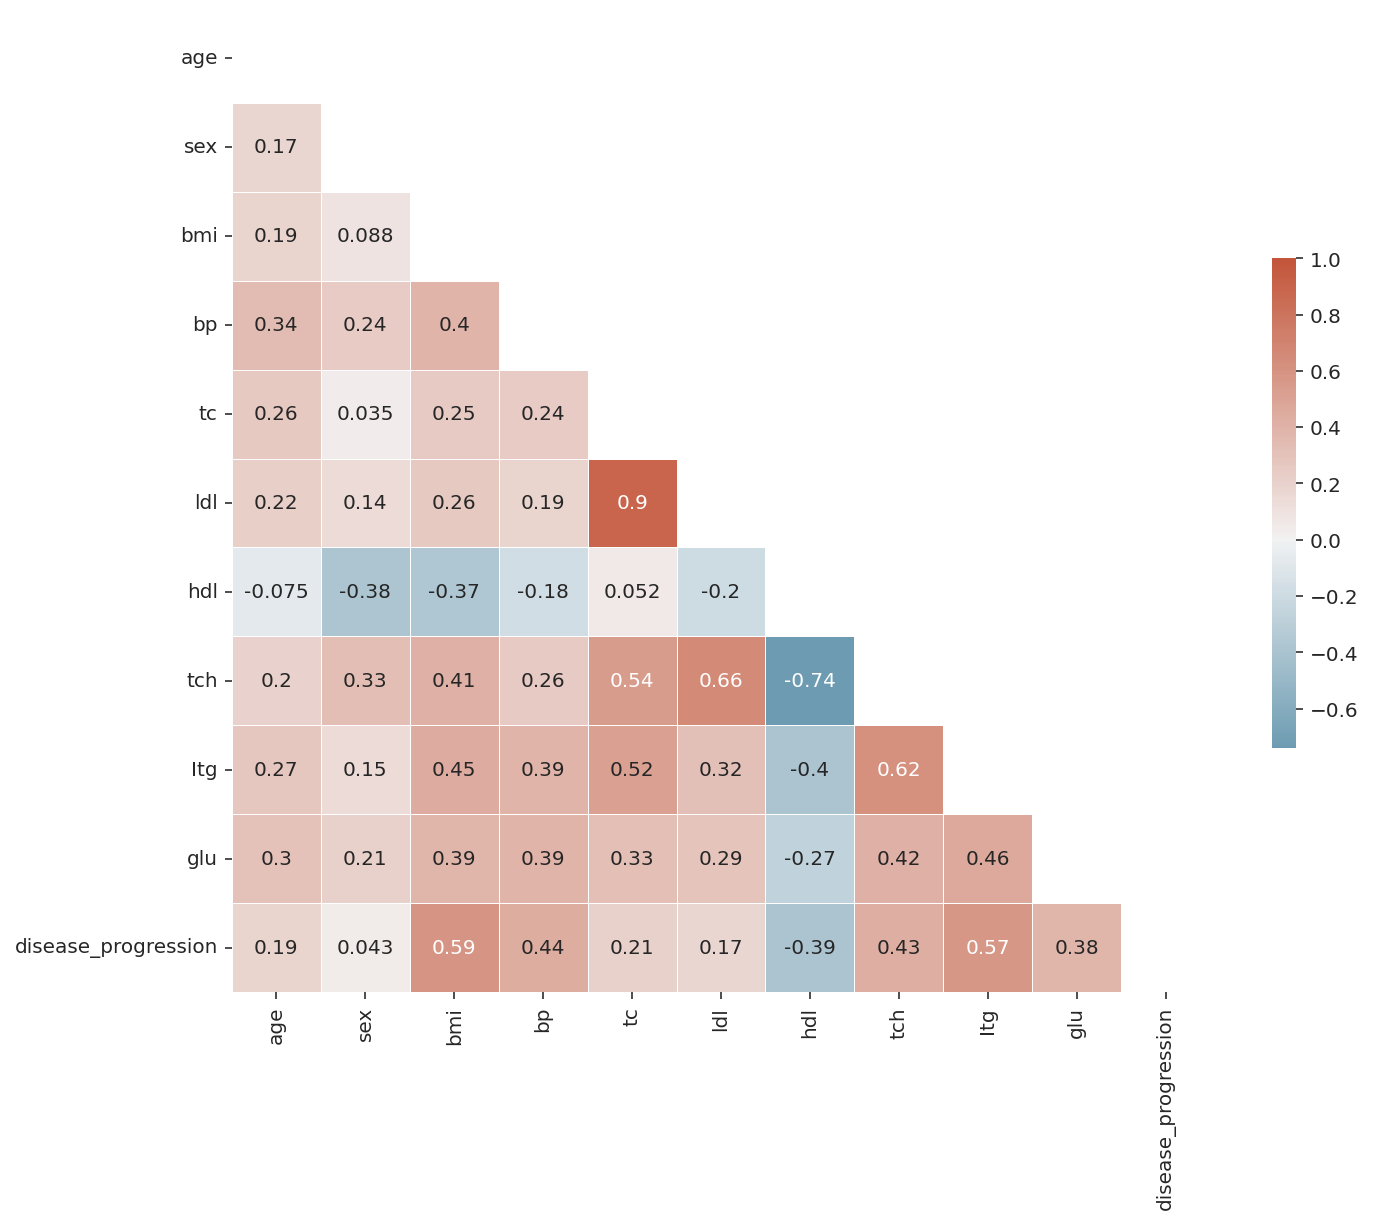

In [ ]:
# Obtenemos la matriz de correlaciones
corr = diabetes.corr()
# Generamos un artificio para hacer ceros por encima de la diagonal
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configuración del gráfico
f, ax = plt.subplots(figsize=(11, 9))
# Paleta de colores
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# gráfico de intensidad
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Las variables que tienen una mayor correlación positiva con la variable objetivo (`disease_progression`) son `bmi` y `ltg`. Por otro lado, la única que tiene correlación negativa es `hdl`.

#### División de muestras

Dividimos el conjunto de datos en dos, de modo que obtenemos un conjunto para entrenar el modelo K-NN (entrenamiento 70%) y otro para examinar la precisión con la que el modelo que acabamos de ajustar (validación 30%) se ajusta a la respuesta.

In [ ]:
# Dividimos entrenamiento y validación
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=42)

#### Solución para un número de k fijo

En primer lugar realizamos el ajuste de regresión con un valor de k que prefijamos. En este caso tomamos `k = 5` y realizamos el ajuste correspondiente. Para valorar el modelo utilizamos las métricas habituales: $R^2$ y MSE. Recordemos que de los dos solo este último resulta útil para comparar modelos y no como valor por si mismo.

En este caso utilizamos las opciones por defecto de algoritmo. Más adelante modificaremos dichas opciones para tratar de mejorar el modelo de partida.

In [ ]:
# ajuste del algoritmo con k=5
knn_diabetes = KNeighborsRegressor(n_neighbors = 5).fit(X_train_diabetes,y_train_diabetes)
# predicciones
y_pred_diabetes_1 = knn_diabetes.predict(X_test_diabetes)
print('El valor del R^2 (para k = 5) = %.3f' % (r2_score(y_test_diabetes, y_pred_diabetes_1)))
print('El valor de MSE (para k = 5) = %.3f' % (mean_squared_error(y_test_diabetes, y_pred_diabetes_1)))
print('El valor de RMSE (para k = 5) = %.3f' % (mean_squared_error(y_test_diabetes, y_pred_diabetes_1, squared = False)))

El valor del R^2 (para k = 5) = 0.403
El valor de MSE (para k = 5) = 3222.118
El valor de RMSE (para k = 5) = 56.764


#### Búsqueda de k

Dado que el valor de $k$ no es conocido la forma de proceder es realizar un proceso de optimización donde integremos la búsqueda de dicho valor como un parámetro del algoritmo. Para obtener la solución utilizamos GridSearch mediante validación cruzada.

In [ ]:
# Secuencia de valores de k
parameters = {"n_neighbors": range(1, 50)}
# Algoritmos gridsearch
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train_diabetes,y_train_diabetes)
# Solución óptima
gridsearch.best_params_

{'n_neighbors': 14}

El algoritmo con un menor error de predicción (MSE o RMSE) corresponde con un número de vecinos igual a 14. Obtenemos las medidas del error (MSE y RMSE) correspondientes a la opción óptima.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_diabetes)
# Error
print('El valor de RMSE (para k = 14) = %.3f' % (mean_squared_error(y_test_diabetes, test_preds_grid)))
print('El valor de RMSE (para k = 14) = %.3f' % (mean_squared_error(y_test_diabetes, test_preds_grid, squared = False)))

El valor de RMSE (para k = 14) = 3052.429
El valor de RMSE (para k = 14) = 55.249


El valor del MSE mejora de 3222.12 a 3052.43. Podemos ver el resultado gráficamente sin  más que representar los valores predichos con el modelo frente a los valores de validación. Cuanto más próxima este la nube de puntos de la diagonal mayor precisión en el modelo. En el gráfico se aprecia el resultado para el modelo propuesto observándose que la nube de puntos es muy dispersa sobre el modelo perfecto que proporciona la diagonal.

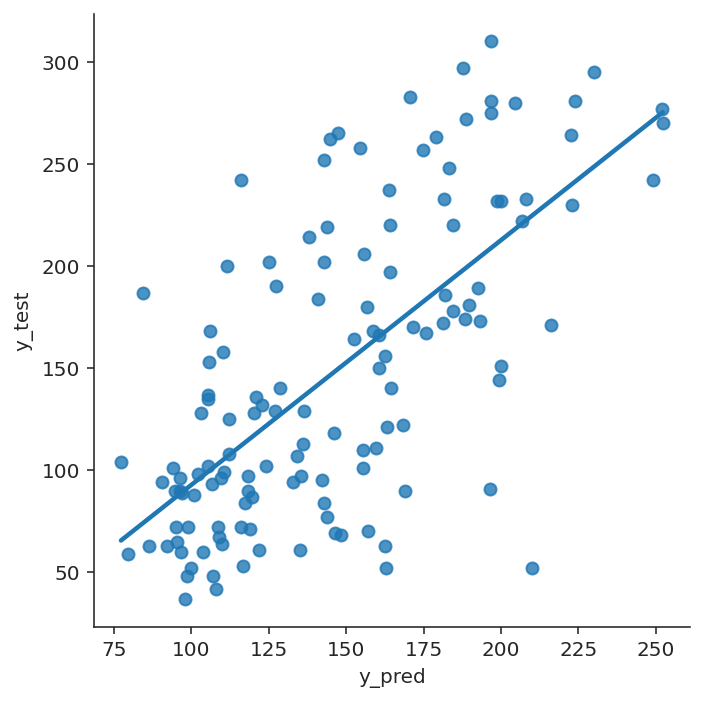

In [ ]:
# Nube de puntos 
datos = pd.DataFrame()
datos["y_test"] = y_test_diabetes
datos["y_pred"] = test_preds_grid
sns.lmplot(data=datos, x="y_pred", y="y_test", ci=None);

#### Mejorando el modelo

Dado que el MSE de validación estimado es bastante grande vamos a tratar de mejorar el modelo de partida modificando algunas de las condiciones iniciales del algoritmo. En concreto modificamos los pesos de los vecinos para que sean el inverso de la distancia al punto que queremos predecir. 

Utilizamos de nuevo gridsearch para realizar la búsqueda tanto de `k` como de los pesos de los vecinos.

In [ ]:
parameters = {
    "n_neighbors": range(1, 50), 
    "weights": ["uniform", "distance"],
    }
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train_diabetes,y_train_diabetes)
GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})
gridsearch.best_params_

{'n_neighbors': 14, 'weights': 'distance'}

La mejor solución se alcanza con 14 vecinos ponderados por la inversa de la distancia. Veamos la mejora del error cometido.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_diabetes)
# Error
print('El valor de MSE (para k = 14) = %.3f' % (mean_squared_error(y_test_diabetes, test_preds_grid)))
print('El valor de RMSE (para k = 14) = %.3f' % (mean_squared_error(y_test_diabetes, test_preds_grid, squared = False)))

El valor de MSE (para k = 14) = 3008.631
El valor de RMSE (para k = 14) = 54.851


Reducimos el MSE en casi 50 unidades consiguiendo un mejor modelo de predicción. Este sería el mejor modelo de predicción que podríamos conseguir para este conjunto de datos utilizando el algoritmo k-NN.

### <font color="steelblue">Meat spec</font>

La base de datos recoge información que ha recopilado un espectrofotómetro, instrumento capaz de detectar la absorbancia que tiene un material a diferentes tipos de luz en función de sus características. El objetivo que se persigue es predecir el contenido en grasa (`fat`) a partir de los valores dados por el espectrofotómetro. Cargamos la base de datos ya preprocesada.

In [ ]:
# meat spec Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/meatspec_clean.csv'
meatspec = pd.read_csv(url, index_col=0)

Una vez cargados los datos identificamos la variable respuesta y las variables predictoras.

In [ ]:
# Asignamos
y_meatspec = meatspec['fat']
X_meatspec = meatspec.drop(columns=['fat'])

Dado que el conjunto de predictoras es muy elevado no se presenta aquí el análisis de correlaciones previo entre respuesta y predictoras.

#### División de muestras

Dividimos la muestra de datos en entrenamiento (70%) y validación (30%).

In [ ]:
# División de muestras 
X_train_meatspec, X_test_meatspec, y_train_meatspec, y_test_meatspec= train_test_split(X_meatspec, y_meatspec, test_size=0.30, random_state=42)

#### Solución para el modelo base

Aplicamos de nuevo gridsearch para encontar el valor óptimo de `k` para las opciones por defecto del algortimo k-NN.

In [ ]:
# Secuencia de valores de k
parameters = {"n_neighbors": range(1, 50)}
# Algoritmos gridsearch
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train_meatspec,y_train_meatspec)
# Solución óptima
gridsearch.best_params_

{'n_neighbors': 1}

La solución óptima se consigue con un único vecino. Vemos el error que se comete con este modelo.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_meatspec)
# Error
print('El valor de RMSE (para k = 1) = %.3f' % (mean_squared_error(y_test_meatspec, test_preds_grid)))
print('El valor de RMSE (para k = 1) = %.3f' % (mean_squared_error(y_test_meatspec, test_preds_grid, squared = False)))

El valor de RMSE (para k = 1) = 0.613
El valor de RMSE (para k = 1) = 0.783


El error MSE para la muestra de validación cometido es de 0.61. Representamos la solución obtenida. 

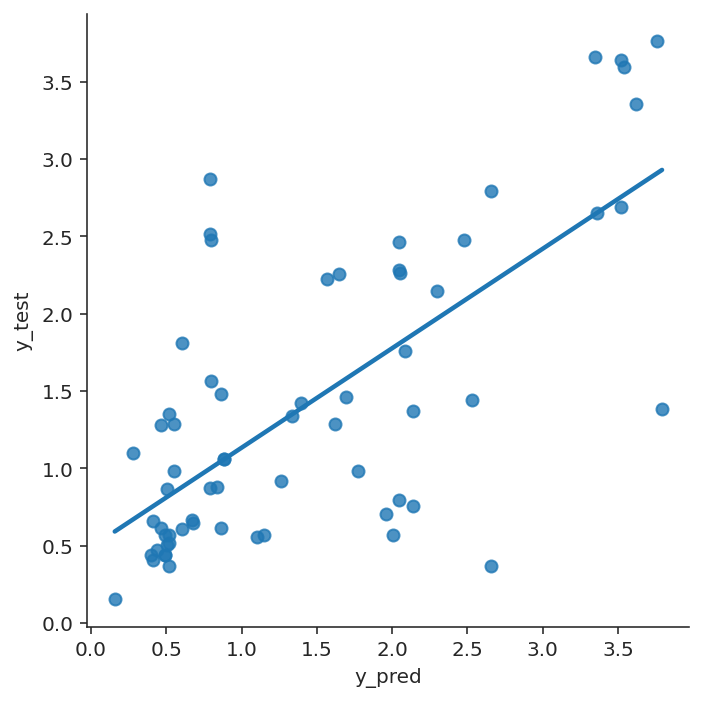

In [ ]:
# Nube de puntos 
datos = pd.DataFrame()
datos["y_test"] = y_test_meatspec
datos["y_pred"] = test_preds_grid
sns.lmplot(data=datos, x="y_pred", y="y_test", ci=None);

#### Mejorando el modelo

Realizamos la búsqueda del modelo óptimo:

In [ ]:
parameters = {
    "n_neighbors": range(1, 50), 
    "weights": ["uniform", "distance"],
    }
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train_meatspec,y_train_meatspec)
GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})
gridsearch.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

La solución óptima se corresponde con cuatro vecinos y pesos como el inverso de la distancia. Veamos el error de validación cometido con este modelo.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_meatspec)
# Error
print('El valor de RMSE (para k = 1) = %.3f' % (mean_squared_error(y_test_meatspec, test_preds_grid)))
print('El valor de RMSE (para k = 1) = %.3f' % (mean_squared_error(y_test_meatspec, test_preds_grid, squared = False)))

El valor de RMSE (para k = 1) = 0.299
El valor de RMSE (para k = 1) = 0.547


Utilizando el modelo óptimo reducimos en más del 50% el error de validación. Vemos gráficamente la solución obtenida.

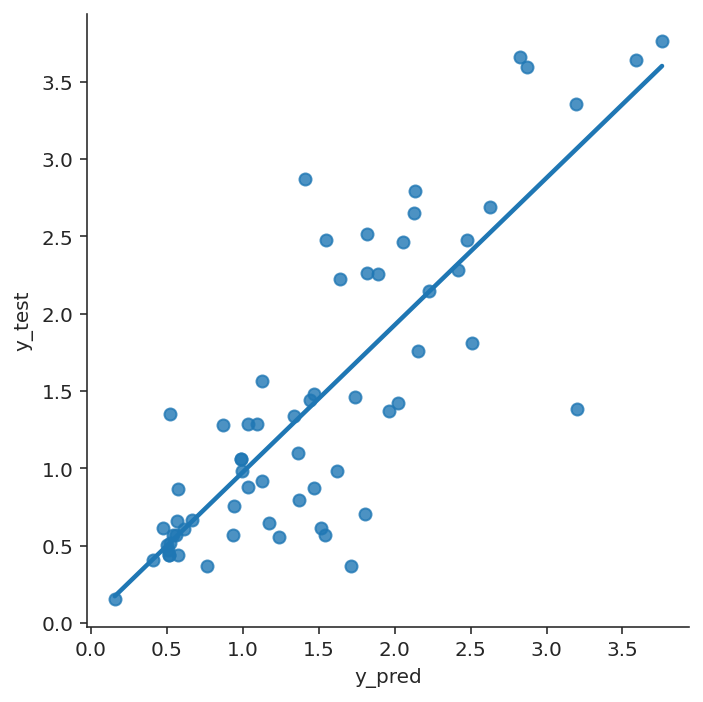

In [ ]:
# Nube de puntos 
datos = pd.DataFrame()
datos["y_test"] = y_test_meatspec
datos["y_pred"] = test_preds_grid
sns.lmplot(data=datos, x="y_pred", y="y_test", ci=None);

Podemos ver en este caso como la nube de puntos se encuentra más proxima a la solución ideal que proporciona la diagonal.

## <font color="steelblue">k-NN en problemas de clasificación</font>

Abordamos ahora el uso del algoritmo k-NN para problemas de clasificación. El procedimiento es muy similar al anterior pero dado que la respuesta es categórica resulta necesario modificar toda la parte de validación del modelo. En este caso utilizamos la exactitud como criterio de validación, y el voto por mayoría para determinar la predicción para una nueva muestra.

### <font color="steelblue">Breast Cancer Wisconsin</font>

En esta base de datos se recoge información sobre los cánceres de mama en la ciudad de Wisconsin. Se describen las características de los núcleos celulares presentes en las imágenes de una resonancia. El objetivo que se persigue es clasificar un tumor como benigno o maligno en función de las variables predictoras. Cargamos la base de datos ya preprocesada y ajustamos un K-NN de clasificación binaria.

In [ ]:
# Breast Cancer Wisconsin
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/cancer_clean.csv'
cancer = pd.read_csv(url, index_col=0)

Asignamos a $y$ la variable `diagnosis` ya que es la variable objetivo y a $X$ el resto de variables de la base de datos.

In [ ]:
# objetivo
y_cancer = cancer['diagnosis']
# matriz de características
X_cancer = cancer.drop(columns=['diagnosis'])

#### Análisis descriptivo

Como el número de predictoras es muy elevado realizamos un análisis gráfico.

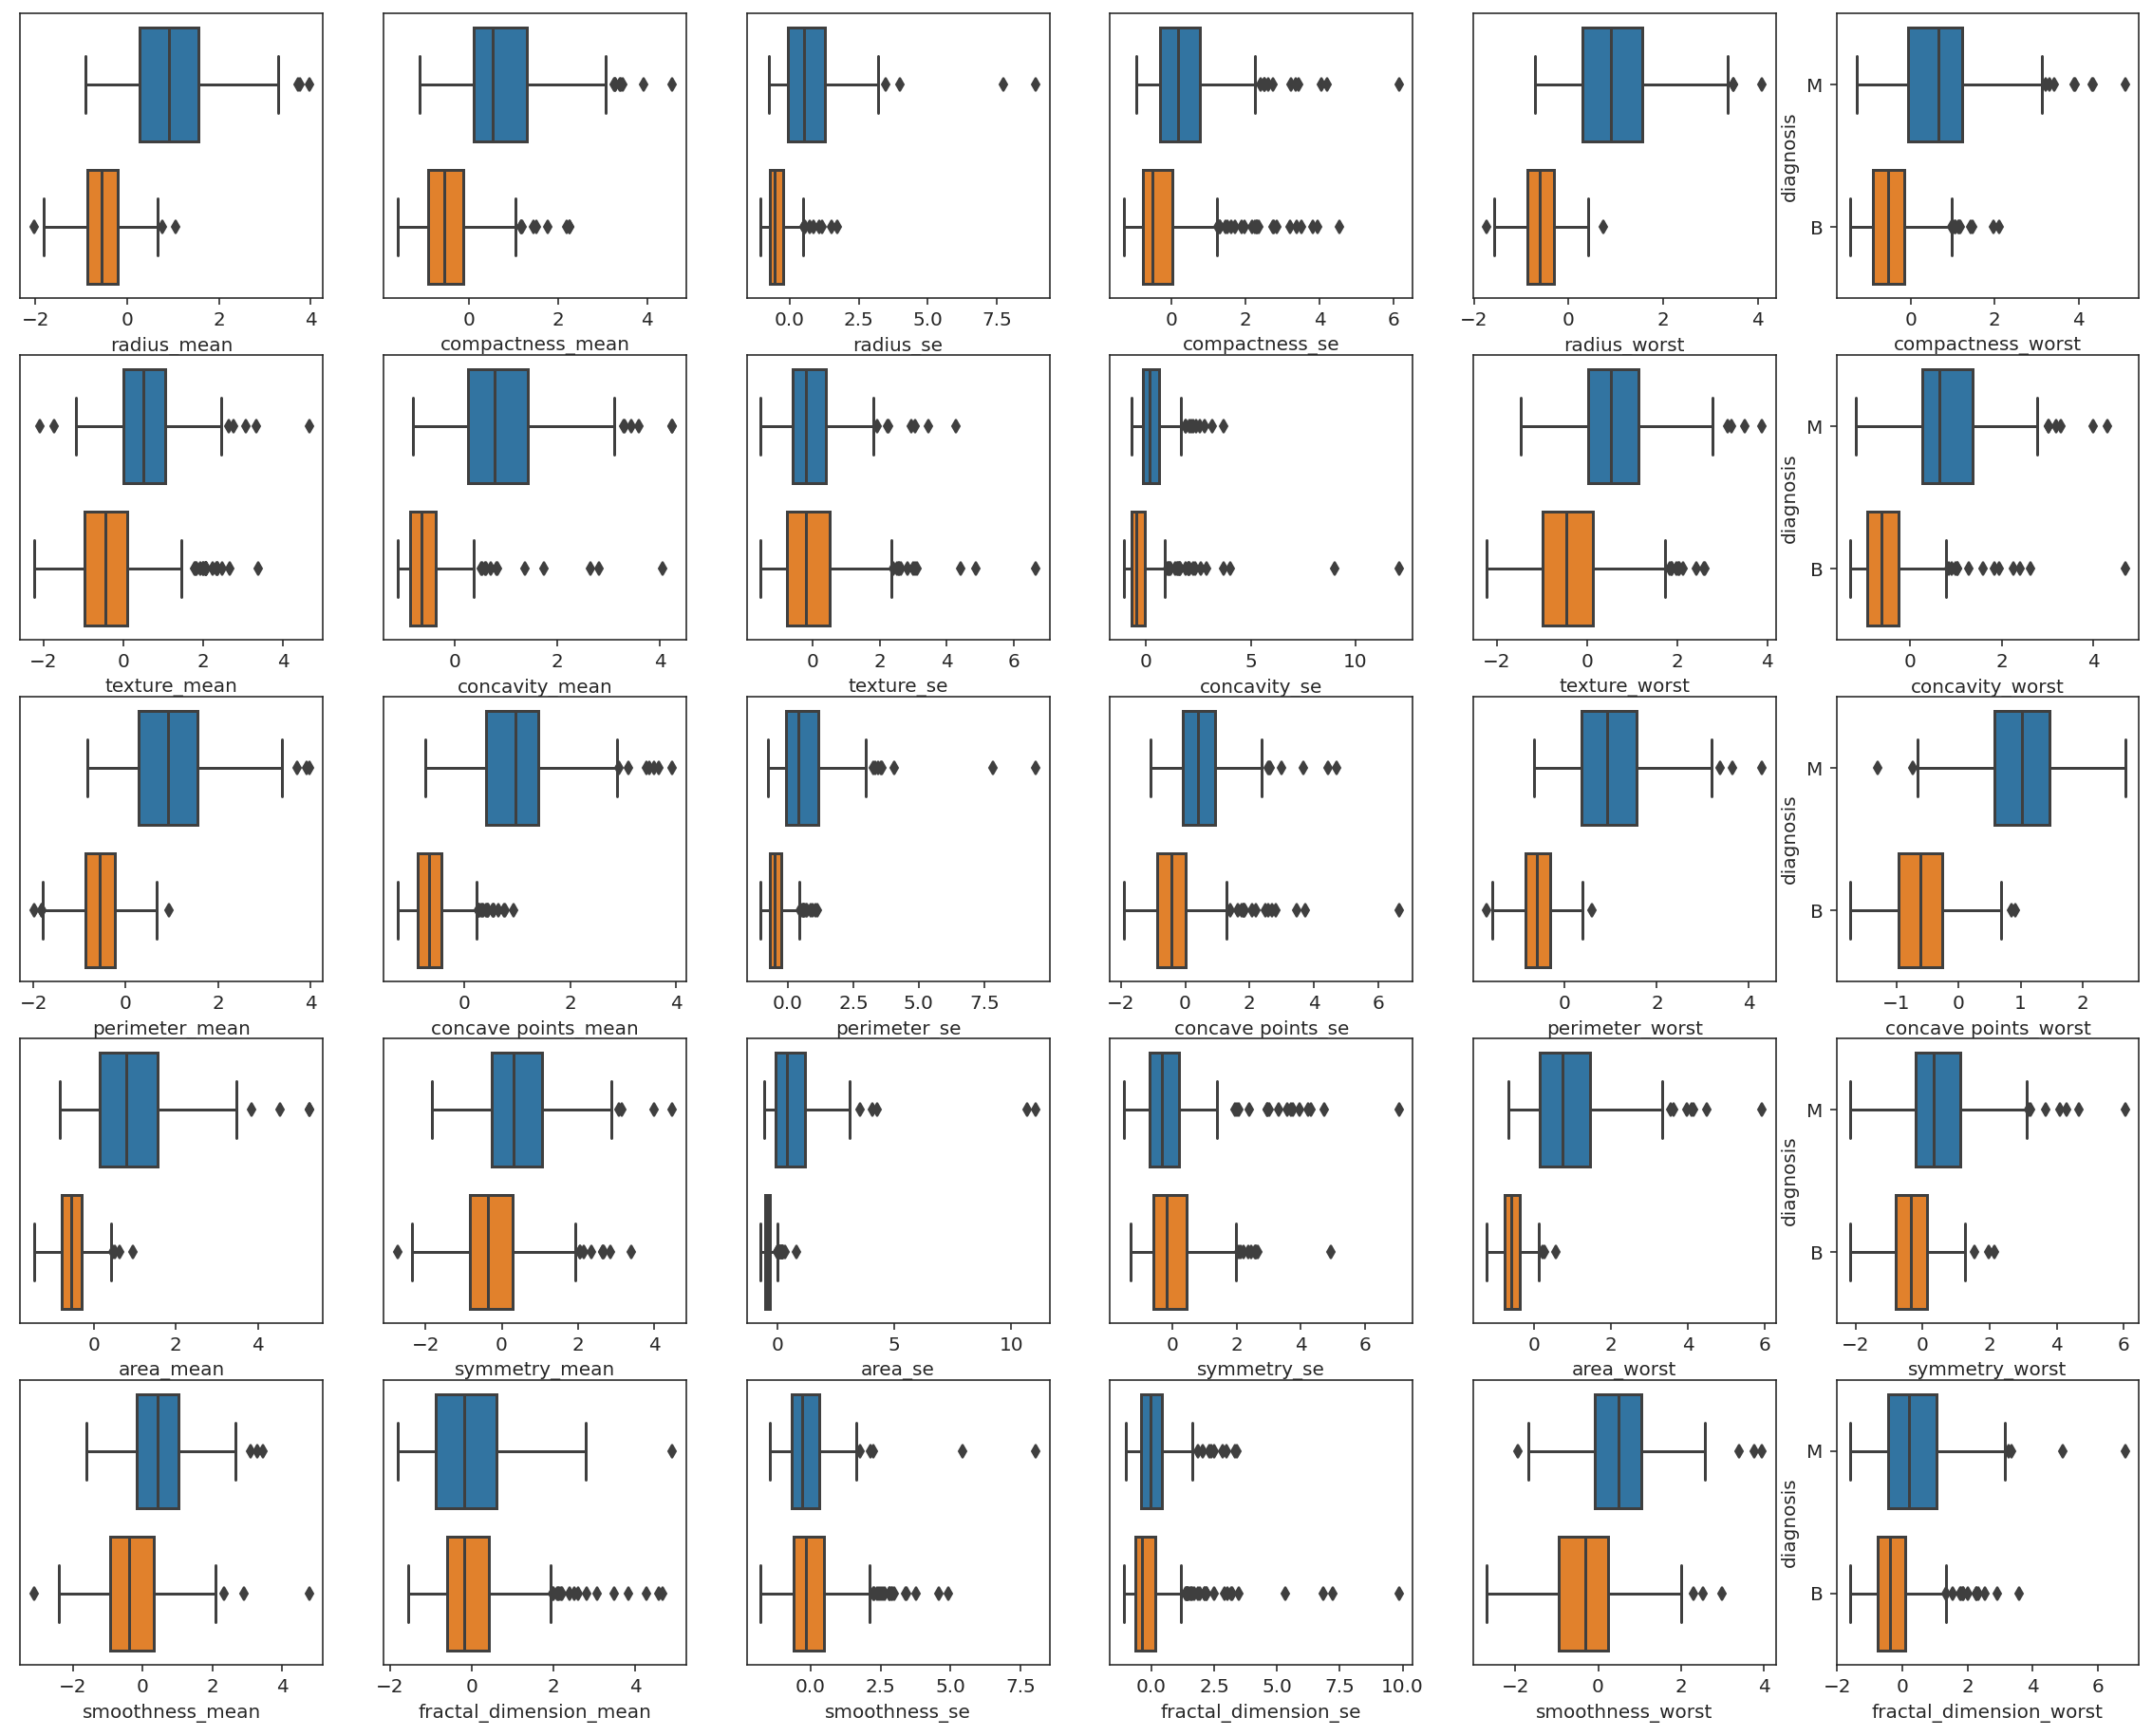

In [ ]:
nombres = cancer.columns
columnas = 6
filas = 5
# Creamos una figura con todos los diagrmas de caja
fig, ax = plt.subplots(nrows=filas, ncols=columnas, figsize=(20, 16))
# asignamos un gráfico a cada ax
for i in range(columnas):
  for j in range(filas):
      sns.boxplot(x = nombres[j+5*i], y = nombres[30] , data = cancer, ax=ax[j,i])
for i in range(filas):
  ax[0,i].set(ylabel='', yticks =[])
  ax[1,i].set(ylabel='', yticks =[])
  ax[2,i].set(ylabel='', yticks =[])
  ax[3,i].set(ylabel='', yticks =[])
  ax[4,i].set(ylabel='', yticks =[])
plt.show()

De esta forma se puede ver claramente que predictoras son las más diferencias producen sobre la respuesta.

#### División de muestras

Dividimos los datos en conjunto de entrenamiento y validación, para ajustar el algoritmo y luego comprobar su validez.

In [ ]:
# Dividimos entrenamiento y validación
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.3, random_state=0)

#### Selección de k

Procedemos buscando el `k` óptimo en esta situación medainte gridsearch.

In [ ]:
# Secuencia de valores de k
parameters = {"n_neighbors": range(1, 50)}
# Algoritmos gridsearch
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train_cancer,y_train_cancer)
# Solución óptima
gridsearch.best_params_

{'n_neighbors': 7}

El óptimo se alcanza con 7 vecinos. Obtenemos la exactitud para la muestra de validación correspondiente a este modelo.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_cancer)
# Precisión
test_acc = accuracy_score(y_test_cancer, test_preds_grid)
np.round(test_acc, 3)

0.953

La exactitud es del 95.3% indicando que el algortimo de clasificación tiene muy buenos resultados. Para profundizar en el análisis de este modelo obtenemos el informe de clasificación perfecto y el AUC score.

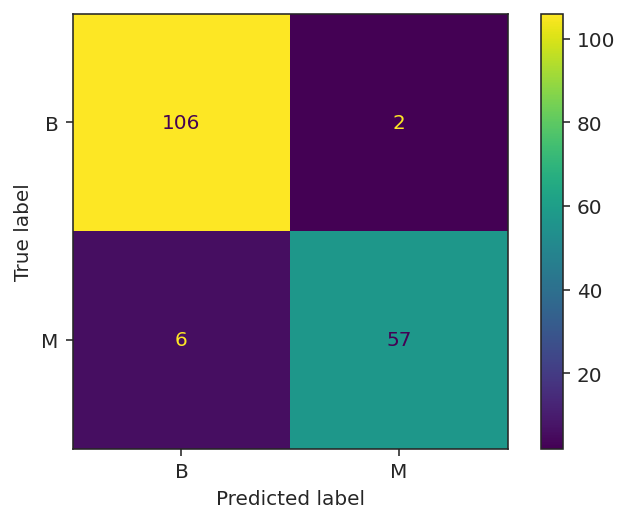

In [ ]:
# Matriz de confusión 
cm_cancer = confusion_matrix(y_test_cancer, test_preds_grid, labels = gridsearch.classes_)
# Solución gráfica
disp_cancer = ConfusionMatrixDisplay(confusion_matrix=cm_cancer, display_labels=gridsearch.classes_)
# Representamos
disp_cancer.plot();

En la matriz de clasificación podemos ver como hay 163 muestras clasificadas correctamente mientras que solo 8 se clasifican de manera incorrecta. Esta clasificación es muy buena, como suponíamos anteriormente al obtener un valor en la exactitud próximo a 1. El error de clasificación más grande ocurre cuando clasificamos como benignos tumores que son malignos (6 errores). Obtenemos el informe de clasificación completo correspondiente al modelo obtenido.

In [ ]:
# Información de la clasificación 
clasif_cancer=classification_report(y_test_cancer, test_preds_grid)
print(clasif_cancer)

              precision    recall  f1-score   support

           B       0.95      0.98      0.96       108
           M       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



En el informe completo de clasificación podemos ver que hay una mayor precisión a la hora de clasificar los tumores malignos (97%) que los benignos (95%). Esto implica que cuando es maligno tenemos más certeza de que lo clasificaremos como maligno. Los resultados obtenidos son bastante buenos. Calculamos del AUC score.

In [ ]:
# Obtenemos probabilidades
y1_probs = gridsearch.predict_proba(X_test_cancer)
# Calculamos score
round(roc_auc_score(y_test_cancer, y1_probs[:,1]),3)

0.992

El score está muy próximo a 1 indicando el buen funcionamiento del algoritmo de clasificación en esta situación.

#### Mejorando el modelo

Aunque los resultados obtenidos son muy buenos tratamos de mejorar el modelo buscando el óptimo de `k` y los pesos utilizados. 

In [ ]:
parameters = {
    "n_neighbors": range(1, 50), 
    "weights": ["uniform", "distance"],
    }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train_cancer,y_train_cancer)
GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})
gridsearch.best_params_

{'n_neighbors': 12, 'weights': 'distance'}

El óptimo se alcanza con 12 vecinos y pesos con el inverso de la distancia. Analizamos los resultados para este modelo.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_cancer)
# Precisión
test_acc = accuracy_score(y_test_cancer, test_preds_grid)
np.round(test_acc, 3)

0.959

Dado que el modelo de base ya funcionaba bastante bien mejorarlo resulta bastante difícil. Pasamos de una exactitud del 95.3% al 95.9%. Dado que los resultados son muy similares obtenemos únicamente el AUC score.

In [ ]:
# Obtenemos probabilidades
y1_probs = gridsearch.predict_proba(X_test_cancer)
# Calculamos score
round(roc_auc_score(y_test_cancer, y1_probs[:,1]),3)

0.992

El score obtenido es idéntico al del modelo base incidiendo en el hecho de que la mejora de este último no es muy relevante debido a que el primero ya proporciona excelentes resultados.

### <font color="steelblue">Abalone</font>

Como vimos en cuadernos anteriores, la base de datos recoge información sobre los abulones y estamos interesados en medir su desarrollo que viene determinado principalmnete por su desarrollo sexual.

Cargamos la base de datos que en este caso no ha sido pretratada. Aunque no hay valores perdidos es necesario estandarizar las predictoras.

In [ ]:
# abalone
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/abalone.csv'
abalone = pd.read_csv(url)

Realizamos la estandarización y la separación en matriz de predictoras y respuesta.

In [ ]:
from sklearn.preprocessing import StandardScaler 
# Preparamos datos
X_abalone = abalone.drop(columns='Sex')
y_abalone = abalone['Sex'].astype('category')
# Estandarizamos datos
sc = StandardScaler()
X_abalone_std = sc.fit_transform(X_abalone)

#### Análisis descriptivo

Realizamos un análisis gráfico de la respuesta frente a cada predictora.

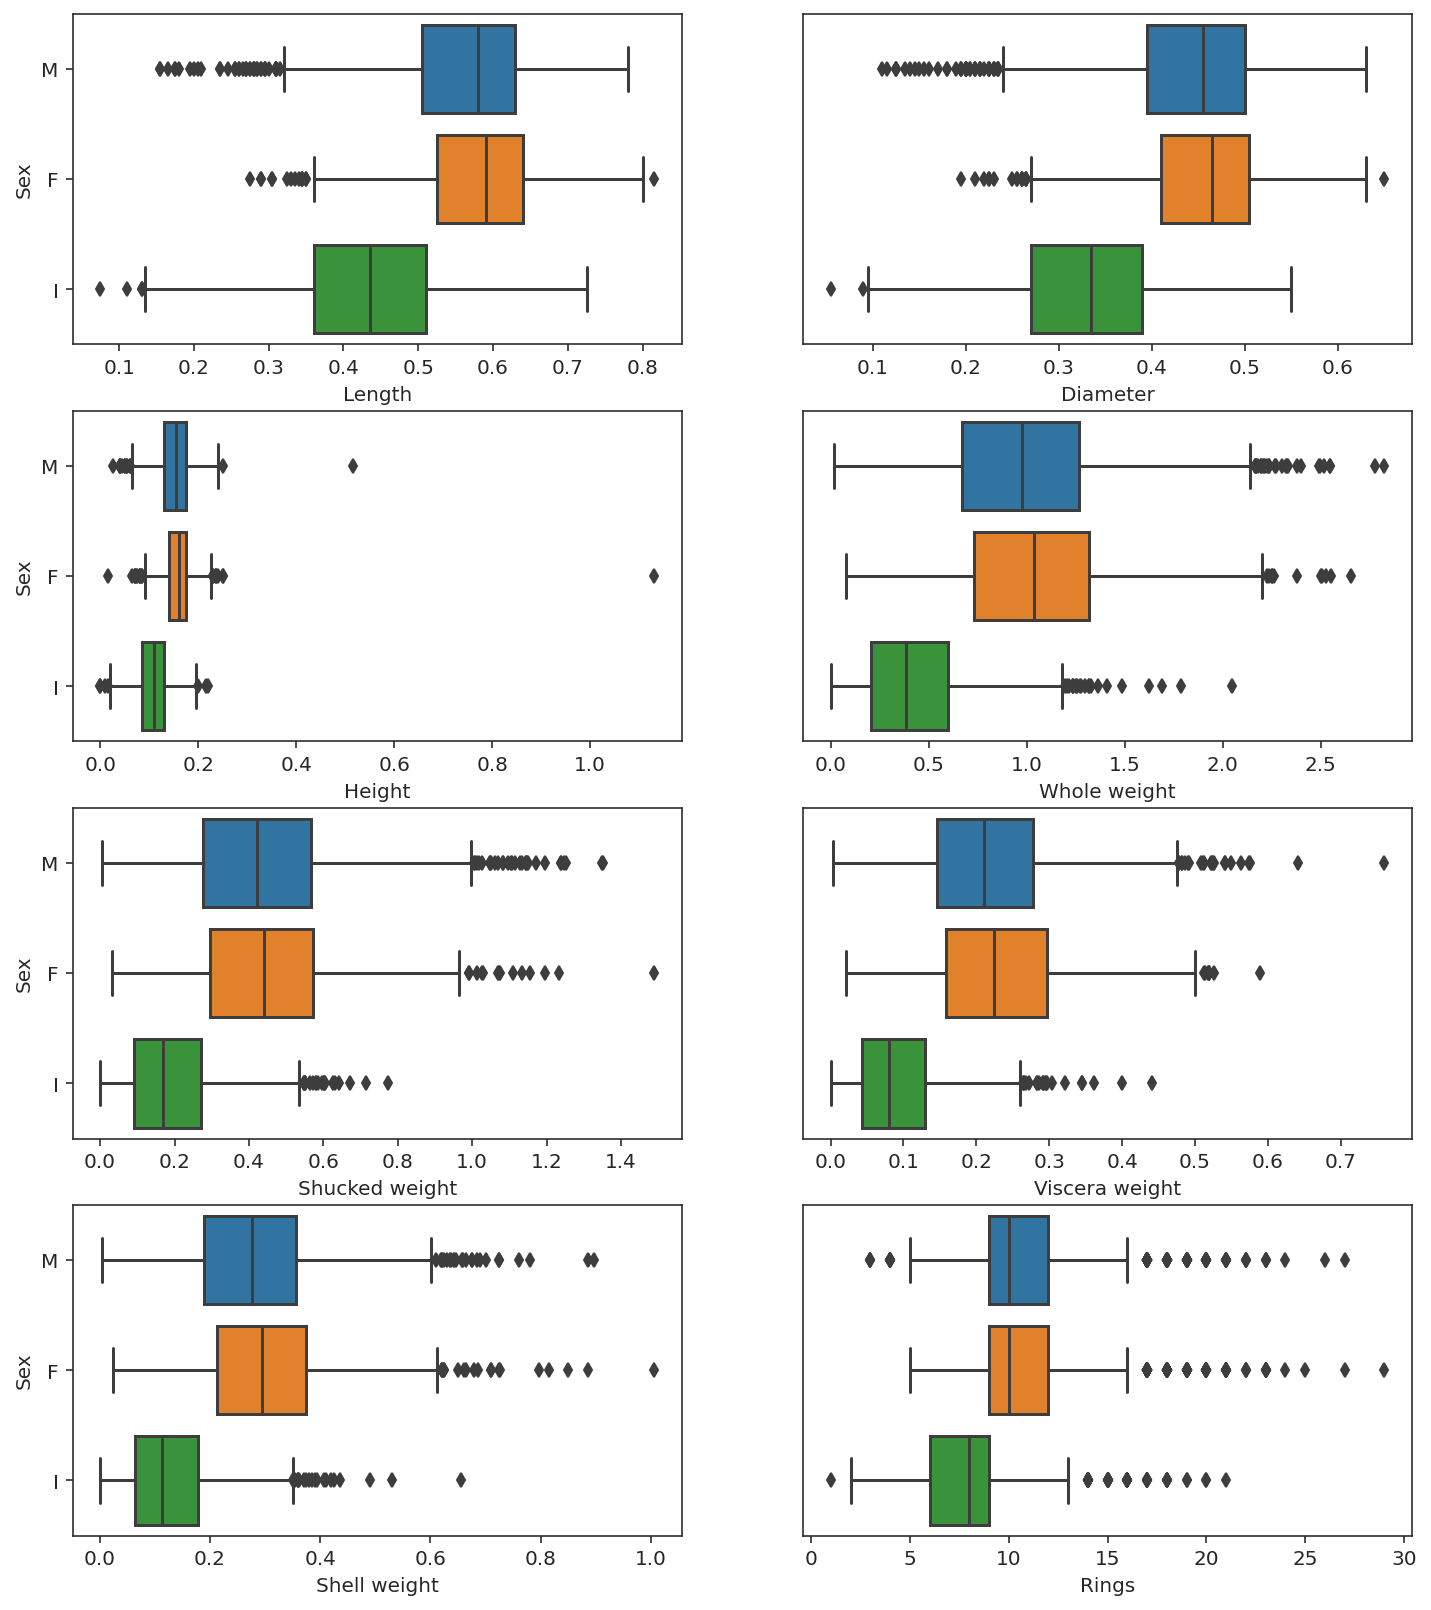

In [ ]:
# Creamos una figura con todos los diagrmas de caja
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
# asignamos un gráfico a cada ax
sns.boxplot(x = "Length", y = "Sex" , data = abalone, ax=ax[0,0])
sns.boxplot(x = "Diameter", y = "Sex" , data = abalone, ax=ax[0,1])
ax[0,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Height", y = "Sex" , data = abalone, ax=ax[1,0])
sns.boxplot(x = "Whole weight", y = "Sex" , data = abalone, ax=ax[1,1])
ax[1,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Shucked weight", y = "Sex" , data = abalone, ax=ax[2,0])
sns.boxplot(x = "Viscera weight", y = "Sex" , data = abalone, ax=ax[2,1])
ax[2,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Shell weight", y = "Sex" , data = abalone, ax=ax[3,0])
sns.boxplot(x = "Rings", y = "Sex" , data = abalone, ax=ax[3,1])
ax[3,1].set(ylabel='', yticks =[])
plt.show()

#### División de muestras

Dividimos los datos en conjunto de entrenamiento y validación, para ajustar el algoritmo y luego comprobar su validez.

In [ ]:
# División de muestras estandarizadas
X_train_abalone, X_test_abalone, y_train_abalone, y_test_abalone = train_test_split(X_abalone_std, y_abalone, test_size=0.30, random_state=0)

#### Selección de k

Procedemos buscando el `k` óptimo en esta situación. 

In [ ]:
# Secuencia de valore de k
parameters = {"n_neighbors": range(1, 50)}
# Algoritmos gridsearch
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train_abalone,y_train_abalone)
# Solución óptima
gridsearch.best_params_

{'n_neighbors': 26}

El óptimo se alcanza con 26 vecinos. Analizamos la solución obtenida.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_abalone)
# Precisión
test_acc = accuracy_score(y_test_abalone, test_preds_grid)
np.round(test_acc, 3)

0.56

La exactitud obtenida (56%) no es muy alta indicando que el algoritmo de clasificación no produce buenos resultados para este conjunto de datos. Obtenemos la tabla de confusión para ver donde se producen mayores errores de clasificación. 

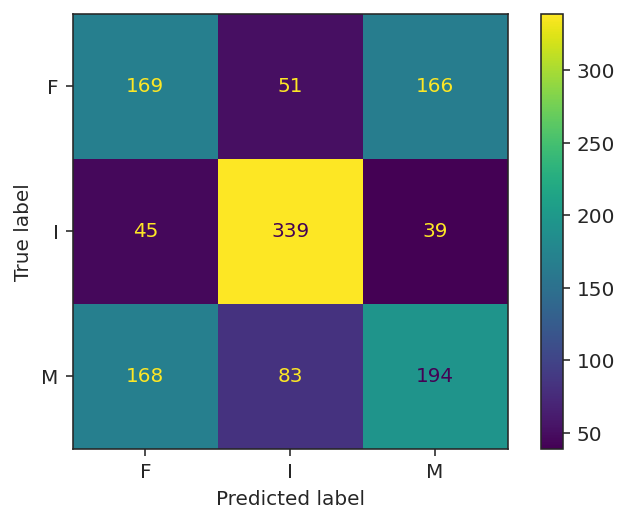

In [ ]:
# Matriz de confusión 
cm_abalone = confusion_matrix(y_test_abalone, test_preds_grid, labels = gridsearch.classes_)
# Solución gráfica
disp_abalone = ConfusionMatrixDisplay(confusion_matrix=cm_abalone, display_labels=gridsearch.classes_)
# Representamos
disp_abalone.plot();

A simple vista se puede ver que los problemas más grandes aparecen con la clasificación de individuos adultos. Resulta muy díficil diferenciar machos y hembras ya que los valores de clasificación entre observados y predichos son muy similares mientras que con los sujetos infantiles resulta un poco más fácil. Una modificación de la respuesta que diferencia entre adultos (sin distinguir por sexo) e infantiles arrojaría mejores resultados de clasificación.

#### Mejorando el modelo

Tratamos de mejorar el modelo anterior utilizando el mismo procedimiento que en los ejemplos anteriores. Planteamos un gridsearch de búsqueda para optimizar los parámetros de entrada del modelo.

In [ ]:
parameters = {
    "n_neighbors": range(1, 50), 
    "weights": ["uniform", "distance"],
    }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train_abalone,y_train_abalone)
GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})
gridsearch.best_params_

{'n_neighbors': 35, 'weights': 'distance'}

El óptimo se alcanza con 35 vecinos y pesos basados en el inverso de la distancia. Analizamos el modelo obtenido valorando en primer lugar la exactitud conseguida.

In [ ]:
# Predicciones
test_preds_grid = gridsearch.predict(X_test_abalone)
# Precisión
test_acc = accuracy_score(y_test_abalone, test_preds_grid)
np.round(test_acc, 3)

0.561

Tan solo mejoramos la clasificación en un 0.1% con lo que el modelo inicial y este tienen resultados muy similares. Para corroborar este hecho obtenemos la matriz de confusión asociada.

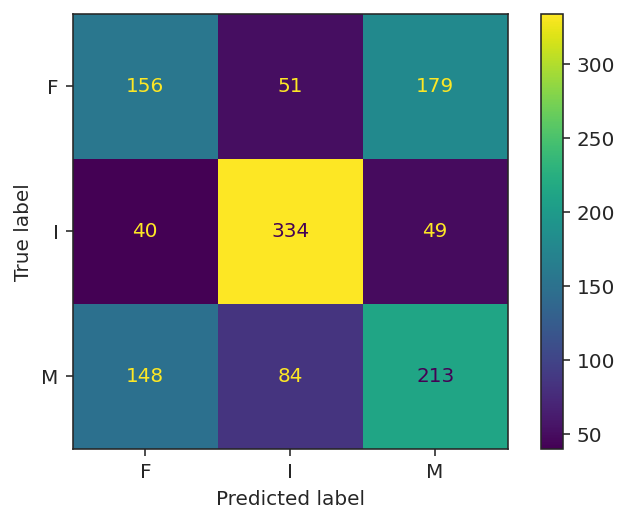

In [ ]:
# Matriz de confusión 
cm_abalone = confusion_matrix(y_test_abalone, test_preds_grid, labels = gridsearch.classes_)
# Solución gráfica
disp_abalone = ConfusionMatrixDisplay(confusion_matrix=cm_abalone, display_labels=gridsearch.classes_)
# Representamos
disp_abalone.plot();

Como se puede ver hemos mejorado la clasificación sobre los machos pero sin embargo empeoramos tanto en las hembras como en los sujetos infantiles. 

# <font color="steelblue">Referencias y enlaces de interés</font>





Manuales

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media.

* Peters Morgan (2018). Data Analysis From Scratch With Python: Beginner Guide using Python, Pandas, NumPy, Scikit-Learn, IPython, TensorFlow and Matplotlib. AI Sciences LLC.

* Sebastian Raschka, Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. Packt Publishing.

* Julian Avila (2017). Scikit-Learn Cookbook: Over 80 Recipes for Machine Learning in Python With Scikit-Learn. Packt Publishing

Enlaces

* Scikit-Learn. Nearest Neighbors: https://scikit-learn.org/stable/modules/neighbors.html#classification

* The k-Nearest Neighbors (kNN) Algorithm in Python. https://realpython.com/knn-python/

